In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,classification_report
from sklearn.decomposition import PCA
import numpy as np

# Initial Data Preparation

In [3]:
# ensure the dataset in a subfolder called data as below
data_file = "data/Epileptic Seizure Recognition.csv"

In [4]:
df = pd.read_csv(data_file)

In [5]:
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [6]:
print(f'Data set has {df.shape[0]:,} samples and {df.shape[1]} features.')

Data set has 11,500 samples and 180 features.


In [7]:
print('Initial distribution of class labels:')
print(df.y.value_counts())

Initial distribution of class labels:
y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64


In [8]:
# remove unusued column
df.drop('Unnamed', axis=1, inplace=True)

In [9]:
# classify having epileptic seizure or non-seisure
class_relabeling = {1:1, 2:0, 3:0, 4:0, 5:0}
df.replace({'y': class_relabeling}, inplace=True)

In [10]:
counts = df['y'].value_counts()
print(f"Number of records epileptic (class=1) {counts[1]:,} vs non-epileptic (class=0) {counts[0]:,}")

Number of records epileptic (class=1) 2,300 vs non-epileptic (class=0) 9,200


In [11]:
# describe non-epileptic data
df[df['y'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
X1,9200.0,-8.992609,70.455286,-566.0,-44.0,-7.0,26.0,1726.0
X2,9200.0,-8.877174,70.560110,-609.0,-44.0,-7.0,27.0,1713.0
X3,9200.0,-8.910435,70.372582,-594.0,-45.0,-7.0,28.0,1697.0
X4,9200.0,-8.969783,70.030409,-549.0,-45.0,-8.0,27.0,1612.0
X5,9200.0,-9.085326,69.377958,-603.0,-45.0,-8.0,27.0,1437.0
...,...,...,...,...,...,...,...,...
X175,9200.0,-9.848587,69.550894,-570.0,-45.0,-9.0,27.0,1958.0
X176,9200.0,-9.620435,70.353607,-594.0,-46.0,-8.0,27.0,2047.0
X177,9200.0,-9.395435,70.934300,-563.0,-45.0,-9.0,27.0,2047.0
X178,9200.0,-9.240435,71.185850,-559.0,-45.0,-8.0,27.0,1915.0


In [12]:
# describe epileptic data
df[df['y'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
X1,2300.0,-21.936522,342.361939,-1839.0,-193.25,-16.0,159.00,1314.0
X2,2300.0,-19.049130,343.398782,-1838.0,-191.25,-18.0,168.25,1356.0
X3,2300.0,-15.293913,337.489643,-1835.0,-187.00,-12.5,169.25,1274.0
X4,2300.0,-9.836087,332.354833,-1845.0,-184.00,-6.0,166.25,1226.0
X5,2300.0,-3.707391,332.211163,-1791.0,-174.25,-12.0,170.00,1518.0
...,...,...,...,...,...,...,...,...
X175,2300.0,-25.830870,339.650467,-1863.0,-195.00,-14.5,153.25,1205.0
X176,2300.0,-25.043913,335.747017,-1781.0,-192.00,-18.0,150.00,1371.0
X177,2300.0,-24.548261,335.244512,-1727.0,-190.25,-21.5,151.25,1445.0
X178,2300.0,-24.016522,339.819309,-1829.0,-189.00,-23.0,157.25,1380.0


# Split Dataset into Train/Validation/Test

In [13]:
# Partition the dataset into X and y
y = df.y
X = df.drop(columns=['y'])

In [14]:
# Split the data into training (60%), validation (%20), and test sets (%20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [15]:
# check the class distributions after the split
print(f'Distribution of  class labels in TRAINING set: Class=1: {y_train.value_counts(normalize=True)[1]},\
    Class=0: {y_train.value_counts(normalize=True)[0]}')
print(f'Distribution of  class labels in VALIDATION set: Class=1: {y_val.value_counts(normalize=True)[1]},\
    Class=0: {y_val.value_counts(normalize=True)[0]}')
print(f'Distribution of  class labels in TEST set: Class=1: {y_test.value_counts(normalize=True)[1]},\
    Class=0: {y_test.value_counts(normalize=True)[0]}')


Distribution of  class labels in TRAINING set: Class=1: 0.2,    Class=0: 0.8
Distribution of  class labels in VALIDATION set: Class=1: 0.2,    Class=0: 0.8
Distribution of  class labels in TEST set: Class=1: 0.2,    Class=0: 0.8


In [16]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [17]:
# suppress annoying warnings
import warnings
warnings.filterwarnings("ignore")

# Try Base (Default Parameters) TabNet Model

In [18]:
# Initialize the TabNet classifier to use GPU
tabnet_clf_base = TabNetClassifier(device_name='cuda')

In [19]:
# do base level training of model
tabnet_clf_base.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping    
    max_epochs=100,  # Max number of epochs
    patience=10,    # Early stopping patience
    batch_size=256, # Mini-batch size
    virtual_batch_size=64,  # Virtual batch size
    num_workers=0,  # Set to >0 for multiprocessing
)

epoch 0  | loss: 0.52027 | val_0_auc: 0.87354 |  0:00:01s
epoch 1  | loss: 0.26837 | val_0_auc: 0.94022 |  0:00:02s
epoch 2  | loss: 0.26724 | val_0_auc: 0.95901 |  0:00:03s
epoch 3  | loss: 0.24009 | val_0_auc: 0.94573 |  0:00:04s
epoch 4  | loss: 0.24156 | val_0_auc: 0.95797 |  0:00:05s
epoch 5  | loss: 0.23738 | val_0_auc: 0.94978 |  0:00:06s
epoch 6  | loss: 0.2281  | val_0_auc: 0.96148 |  0:00:07s
epoch 7  | loss: 0.23069 | val_0_auc: 0.96125 |  0:00:08s
epoch 8  | loss: 0.22881 | val_0_auc: 0.96156 |  0:00:09s
epoch 9  | loss: 0.2335  | val_0_auc: 0.95963 |  0:00:09s
epoch 10 | loss: 0.21907 | val_0_auc: 0.96218 |  0:00:10s
epoch 11 | loss: 0.22037 | val_0_auc: 0.9511  |  0:00:11s
epoch 12 | loss: 0.22603 | val_0_auc: 0.96048 |  0:00:12s
epoch 13 | loss: 0.20265 | val_0_auc: 0.971   |  0:00:13s
epoch 14 | loss: 0.20193 | val_0_auc: 0.95751 |  0:00:14s
epoch 15 | loss: 0.19949 | val_0_auc: 0.96847 |  0:00:15s
epoch 16 | loss: 0.18871 | val_0_auc: 0.97192 |  0:00:16s
epoch 17 | los

In [20]:
# Make predictions and evaluate the base model
y_pred = tabnet_clf_base.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
report = classification_report(y_test, y_pred)
print("Classification Report for Base TabNet Model:\n", report)

Accuracy: 94.00%
Classification Report for Base TabNet Model:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1840
           1       0.94      0.74      0.83       460

    accuracy                           0.94      2300
   macro avg       0.94      0.87      0.90      2300
weighted avg       0.94      0.94      0.94      2300



In [21]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1820   20]
 [ 118  342]]


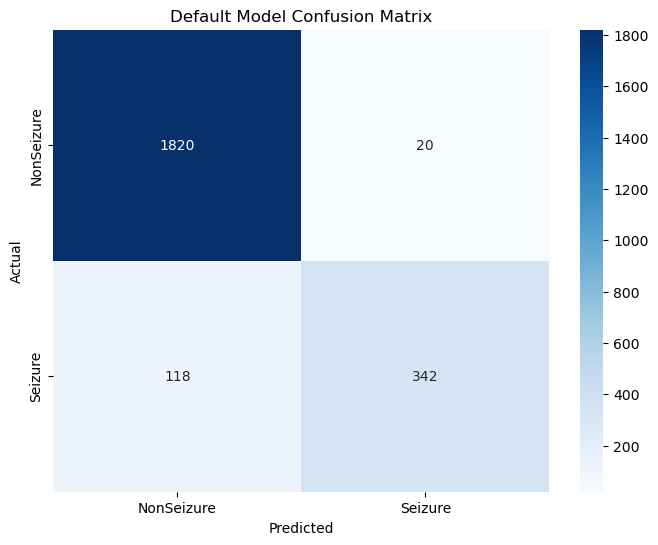

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NonSeizure', 'Seizure'], yticklabels=['NonSeizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Default Model Confusion Matrix')
plt.show()

**Base model has accuracy score of 94%**

# Try TabNet with Top 15 Most Important Features

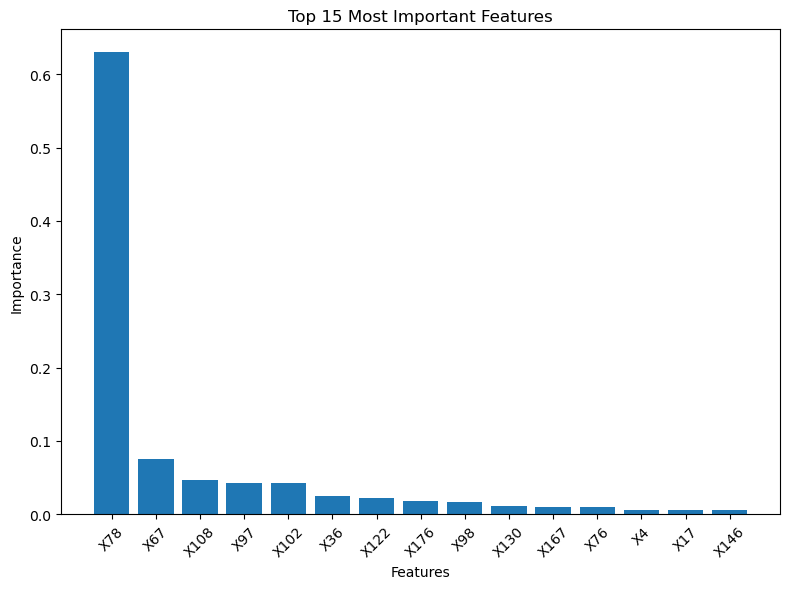

In [23]:
# Get feature importances
feature_importances = tabnet_clf_base.feature_importances_

#let's examine the top features
top_n = 15

# Create a sorted list of (feature, importance) pairs
features_with_importance = sorted(
    zip(X.columns, feature_importances),
    key=lambda x: x[1],
    reverse=True  # Sort by importance in descending order
)

# Extract the top 5 most important features
top_features = features_with_importance[:top_n]

# Separate feature names and their importance values for plotting
top_feature_names = [f[0] for f in top_features]
top_importances = [f[1] for f in top_features]

# Plot the top 5 features
plt.figure(figsize=(8, 6))
plt.bar(top_feature_names, top_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title(f"Top {top_n} Most Important Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Now, focus on only the top features identified 
X_top_n = X[top_feature_names]

In [25]:
# And repeat the split with the restricted feature set: 
# Split the data into training (60%), validation (%20), and test sets (%20)
X_train, X_temp, y_train, y_temp = train_test_split(X_top_n, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [26]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [27]:
# Initialize the TabNet classifier to use GPU
tabnet_clf_top_n = TabNetClassifier(device_name='cuda')

In [28]:
tabnet_clf_top_n.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping    
    max_epochs=100,  # Max number of epochs
    patience=10,    # Early stopping patience
    batch_size=256, # Mini-batch size
    virtual_batch_size=64,  # Virtual batch size
)

epoch 0  | loss: 0.43624 | val_0_auc: 0.91235 |  0:00:00s
epoch 1  | loss: 0.26797 | val_0_auc: 0.9506  |  0:00:01s
epoch 2  | loss: 0.22896 | val_0_auc: 0.94336 |  0:00:02s
epoch 3  | loss: 0.24463 | val_0_auc: 0.95709 |  0:00:03s
epoch 4  | loss: 0.23446 | val_0_auc: 0.95749 |  0:00:04s
epoch 5  | loss: 0.21955 | val_0_auc: 0.96001 |  0:00:04s
epoch 6  | loss: 0.21903 | val_0_auc: 0.96116 |  0:00:05s
epoch 7  | loss: 0.20218 | val_0_auc: 0.95283 |  0:00:06s
epoch 8  | loss: 0.21647 | val_0_auc: 0.95779 |  0:00:07s
epoch 9  | loss: 0.20517 | val_0_auc: 0.96216 |  0:00:08s
epoch 10 | loss: 0.20179 | val_0_auc: 0.96469 |  0:00:08s
epoch 11 | loss: 0.19541 | val_0_auc: 0.97308 |  0:00:09s
epoch 12 | loss: 0.19573 | val_0_auc: 0.96655 |  0:00:10s
epoch 13 | loss: 0.19742 | val_0_auc: 0.9656  |  0:00:11s
epoch 14 | loss: 0.19634 | val_0_auc: 0.96412 |  0:00:11s
epoch 15 | loss: 0.19408 | val_0_auc: 0.96099 |  0:00:12s
epoch 16 | loss: 0.19228 | val_0_auc: 0.96942 |  0:00:13s
epoch 17 | los

In [29]:
# Make predictions and evaluate the base model
y_pred = tabnet_clf_top_n.predict(X_test)
accuracy_top_n = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_top_n * 100:.2f}%")
report_top_n = classification_report(y_test, y_pred)
print(f"Classification Report for Base TabNet Model with top {top_n} features:\n", report_top_n)

Accuracy: 91.91%
Classification Report for Base TabNet Model with top 15 features:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      1840
           1       0.95      0.63      0.76       460

    accuracy                           0.92      2300
   macro avg       0.93      0.81      0.85      2300
weighted avg       0.92      0.92      0.91      2300



**Training TabNet with top 15 features only did not improve accuracy, in fact had worse accuracy at 94%**

# Try TabNet with Important Features Determined by PCA 

In [30]:
# And repeat the split with the full feature set again: 
# Split the data into training (60%), validation (%20), and test sets (%20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [32]:
# Apply PCA
n_components = 50  # Number of principal components to keep
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Check explained variance ratio to confirm retention of important features
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance by {n_components} components: {explained_variance:.2f}")


Explained Variance by 50 components: 0.99


In [33]:
# Initialize the TabNet classifier to use GPU
tabnet_clf_pca = TabNetClassifier(device_name='cuda')

In [34]:
tabnet_clf_pca.fit(
    X_train_pca, y_train,
    eval_set=[(X_val_pca, y_val)],  # Validation set for early stopping
    max_epochs=100,
    patience=5,
    batch_size=1024,
    virtual_batch_size=256,
)

epoch 0  | loss: 0.66565 | val_0_auc: 0.72098 |  0:00:00s
epoch 1  | loss: 0.38387 | val_0_auc: 0.89301 |  0:00:00s
epoch 2  | loss: 0.26963 | val_0_auc: 0.93292 |  0:00:00s
epoch 3  | loss: 0.24095 | val_0_auc: 0.94489 |  0:00:00s
epoch 4  | loss: 0.21352 | val_0_auc: 0.96415 |  0:00:01s
epoch 5  | loss: 0.20135 | val_0_auc: 0.96888 |  0:00:01s
epoch 6  | loss: 0.20274 | val_0_auc: 0.96996 |  0:00:01s
epoch 7  | loss: 0.18899 | val_0_auc: 0.97482 |  0:00:02s
epoch 8  | loss: 0.16926 | val_0_auc: 0.97175 |  0:00:02s
epoch 9  | loss: 0.1724  | val_0_auc: 0.97217 |  0:00:02s
epoch 10 | loss: 0.16205 | val_0_auc: 0.97224 |  0:00:02s
epoch 11 | loss: 0.15196 | val_0_auc: 0.97163 |  0:00:03s
epoch 12 | loss: 0.15361 | val_0_auc: 0.97376 |  0:00:03s

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.97482


In [35]:
# Make predictions and evaluate the base model
y_pred = tabnet_clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_pca * 100:.2f}%")
report_pca = classification_report(y_test, y_pred)
print(f"Classification Report for PCA TabNet Model with {n_components} components:\n", report_pca)

Accuracy: 94.43%
Classification Report for PCA TabNet Model with 50 components:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1840
           1       0.94      0.77      0.85       460

    accuracy                           0.94      2300
   macro avg       0.94      0.88      0.91      2300
weighted avg       0.94      0.94      0.94      2300



**TabNet with PCA did not improve accuracy, it's still close to 94%**

# Try Grid Search on TabNet to Improve Model Hyperparameters

In [36]:
# And repeat the split with the full feature set again: 
# Split the data into training (60%), validation (%20), and test sets (%20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [38]:

# Define the TabNet model and hyperparameters
tabnet_clf_grid = TabNetClassifier(device_name='cuda')

param_grid = {
    'n_d': [8, 24],
    'n_a': [8, 24],
    'n_steps': [3,7],
    'gamma': [1.0, 2.0],
    'lambda_sparse': [0.0001, 0.01]
}

# Set up the stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=tabnet_clf_grid,
    param_grid=param_grid,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    n_jobs=8
)

**WARNING: The next statement will take hours even on a machine with GPU**

In [39]:
# Fit the model using GridSearchCV
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    max_epochs=30,  # Max number of epochs
    patience=5,    # Early stopping patience
    batch_size=256, # Mini-batch size
    virtual_batch_size=64,  # Virtual batch size
    num_workers=0  # Set to >0 for multiprocessing
)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
epoch 0  | loss: 0.40516 | val_0_auc: 0.96328 |  0:00:01s
epoch 1  | loss: 0.24    | val_0_auc: 0.95331 |  0:00:03s
epoch 2  | loss: 0.25241 | val_0_auc: 0.9673  |  0:00:05s
epoch 3  | loss: 0.26144 | val_0_auc: 0.95143 |  0:00:07s
epoch 4  | loss: 0.26728 | val_0_auc: 0.96781 |  0:00:08s
epoch 5  | loss: 0.19637 | val_0_auc: 0.94021 |  0:00:10s
epoch 6  | loss: 0.26989 | val_0_auc: 0.96239 |  0:00:12s
epoch 7  | loss: 0.21285 | val_0_auc: 0.96737 |  0:00:13s
epoch 8  | loss: 0.21968 | val_0_auc: 0.96112 |  0:00:15s
epoch 9  | loss: 0.20463 | val_0_auc: 0.96778 |  0:00:17s

Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_auc = 0.96781


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=TabNetClassifier(cat_dims=[], cat_emb_dim=[], cat_idxs=[], device_name='cuda', grouped_features=[], optimizer_params={'lr': 0.02}, scheduler_params={}),
             n_jobs=8,
             param_grid={'gamma': [1.0, 2.0], 'lambda_sparse': [0.0001, 0.01],
                         'n_a': [8, 24], 'n_d': [8, 24], 'n_steps': [3, 7]},
             scoring='accuracy', verbose=2)

In [42]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)
print("Best Score:", round(best_score,2))

Best Parameters: {'gamma': 1.0, 'lambda_sparse': 0.0001, 'n_a': 24, 'n_d': 24, 'n_steps': 7}
Best Score: 0.93


In [43]:
# Make predictions and evaluate the base model
y_pred = best_model.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_grid * 100:.2f}%")
report_grid = classification_report(y_test, y_pred)
print(f"Classification Report for GRID TabNet Model:\n", report_grid)

Accuracy: 91.43%
Classification Report for GRID TabNet Model:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      1840
           1       0.96      0.60      0.74       460

    accuracy                           0.91      2300
   macro avg       0.93      0.80      0.84      2300
weighted avg       0.92      0.91      0.91      2300



**Grid search did not improve model accuracy beyond the default model parameters.**

# TabNet with Best Model Parameters from Grid Search

In [44]:
# Split the data into training (60%), validation (%20), and test sets (%20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [46]:
# Initialize the TabNet classifier to use GPU
tabnet_clf_best = TabNetClassifier(device_name='cuda',gamma=1,lambda_sparse=0.0001,n_a=24,n_d=24,n_steps=7,verbose=0)

In [47]:
# do base level training of model
tabnet_clf_best.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping    
    max_epochs=500,  # Max number of epochs
    patience=10,    # Early stopping patience
    batch_size=256, # Mini-batch size
    virtual_batch_size=64,  # Virtual batch size
    num_workers=0,  # Set to >0 for multiprocessing
)


Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_auc = 0.97557


In [48]:
# Make predictions and evaluate the base model
y_pred = tabnet_clf_best.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_best * 100:.2f}%")
report_best = classification_report(y_test, y_pred)
print("Classification Report for Best Pars  TabNet Model:\n", report_best)

Accuracy: 93.22%
Classification Report for Best Pars  TabNet Model:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1840
           1       0.91      0.73      0.81       460

    accuracy                           0.93      2300
   macro avg       0.92      0.86      0.89      2300
weighted avg       0.93      0.93      0.93      2300



**TabNet did not improve in accuracy even with the 'best' parameters from a grid search.**

# Conclusion

*Although the TabNet model achieves 94-95% accuracy on this dataset, it is not the best model in this context. TabNet is a good model for time series data, but for this dataset it is not effective due to the time series happening within samples instead of across samples - and TabNet does not appear to exploit this sequential time aspect of individual sample data.*